In [1]:
!pip install kaggle --upgrade


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('imdevskp/corona-virus-report', unzip=True)
df = pd.read_csv('covid_19_clean_complete.csv')

Dataset URL: https://www.kaggle.com/datasets/imdevskp/corona-virus-report


In [6]:
import pandas as pd
import numpy as np

# First check for duplicate columns
print("Before rename - duplicate columns:", df.columns[df.columns.duplicated()].tolist())

# SAFE RENAME - Only rename columns that exist
rename_dict = {}
if 'Country/Region' in df.columns:
    rename_dict['Country/Region'] = 'location'
if 'Date' in df.columns:
    rename_dict['Date'] = 'date'
if 'Confirmed' in df.columns:
    rename_dict['Confirmed'] = 'total_cases'  # Note: Fixed typo from previous version
if 'Deaths' in df.columns:
    rename_dict['Deaths'] = 'total_deaths'

df = df.rename(columns=rename_dict)

# Now verify no duplicates exist
print("After rename - duplicate columns:", df.columns[df.columns.duplicated()].tolist())

# Convert date safely
if 'date' in df.columns:
    try:
        df['date'] = pd.to_datetime(df['date'])
        print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")
    except Exception as e:
        print(f"Date conversion failed: {str(e)}")
else:
    print("Warning: 'date' column not found after renaming")

Before rename - duplicate columns: []
After rename - duplicate columns: []
Date range: 2020-01-22 to 2020-07-27


In [5]:
df = df.loc[:, ~df.columns.duplicated()]

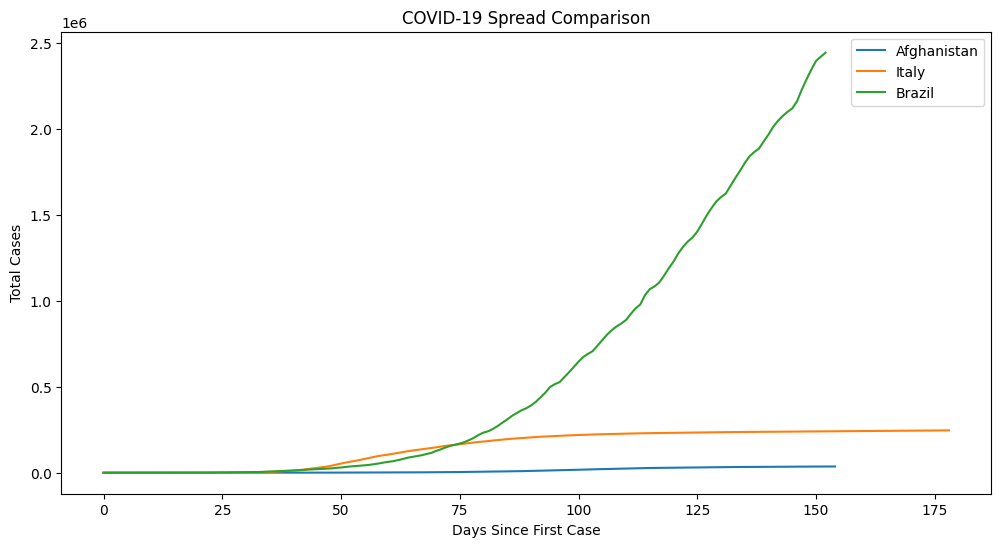

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Filter to meaningful data (remove pre-outbreak zeros)
df = df[df['total_cases'] > 0]

# 2. Calculate outbreak timelines per country
outbreak_start = df.groupby('location')['date'].min().reset_index()
outbreak_start.columns = ['location', 'first_case_date']

# 3. Merge back to original data
df = pd.merge(df, outbreak_start, on='location')
df['days_since_outbreak'] = (df['date'] - df['first_case_date']).dt.days

# 4. Enhanced visualization
plt.figure(figsize=(12,6))
for country in ['Afghanistan', 'Italy', 'Brazil']:  # Example countries
    country_data = df[df['location'] == country]
    plt.plot(country_data['days_since_outbreak'], 
             country_data['total_cases'], 
             label=country)

plt.xlabel('Days Since First Case')
plt.ylabel('Total Cases')
plt.title('COVID-19 Spread Comparison')
plt.legend()
plt.show()

# 5. Advanced metrics
df['doubling_time'] = np.log(2) / df.groupby('location')['case_growth_rate'].rolling(7).mean().reset_index(level=0, drop=True)

Dataset URL: https://www.kaggle.com/datasets/imdevskp/corona-virus-report


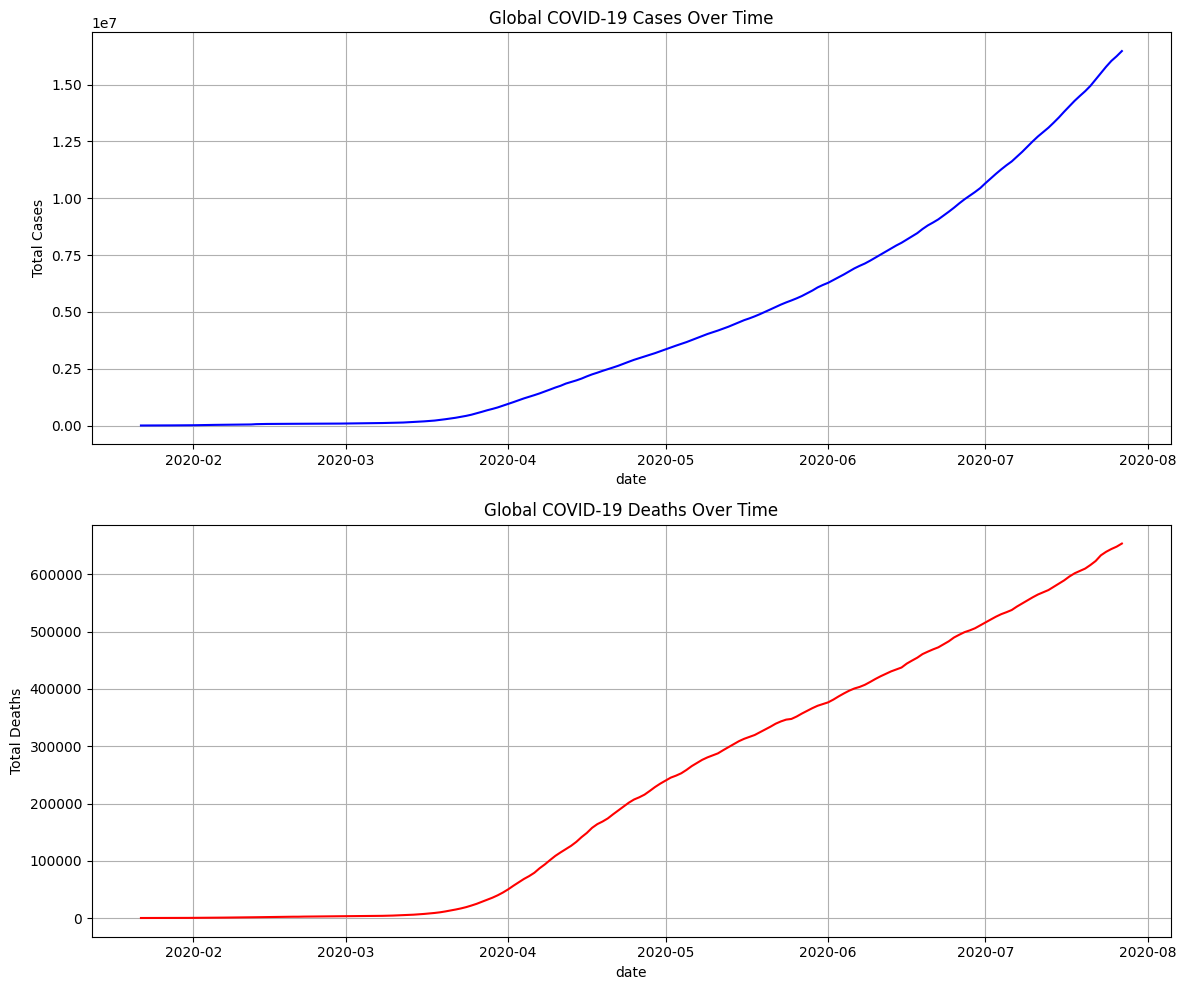

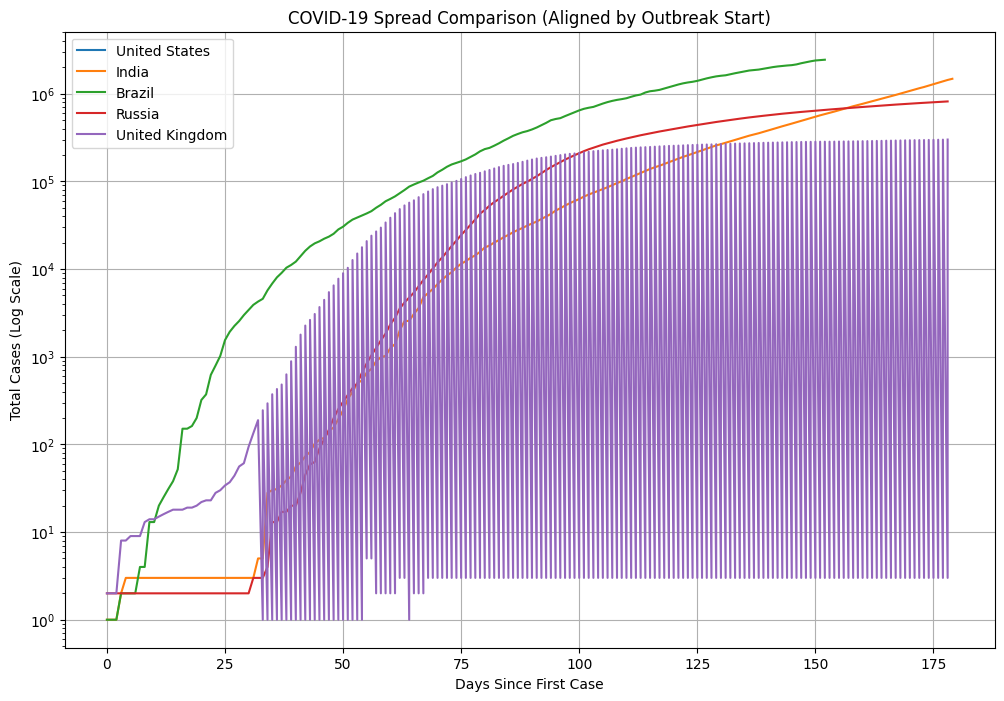

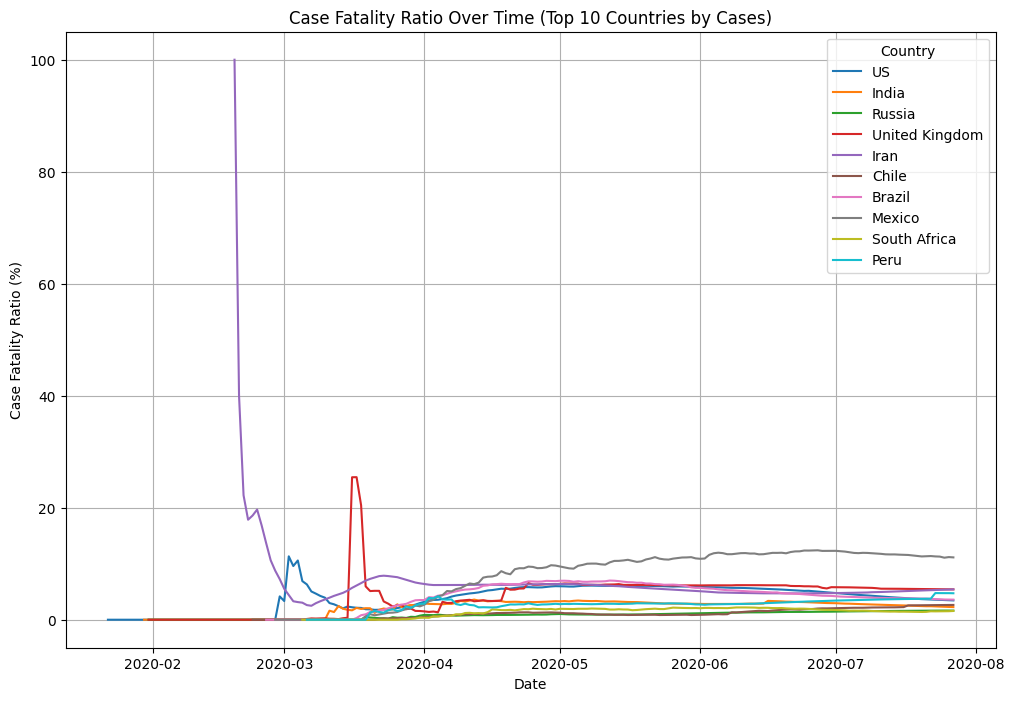

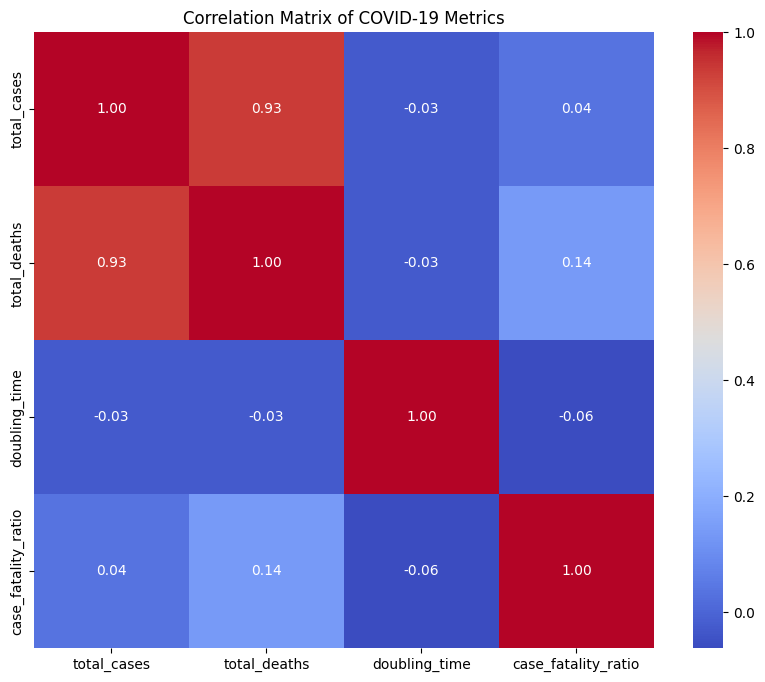


Key Global Statistics:
Total Countries Affected: 187
Total Cases Worldwide: 4,290,259
Total Deaths Worldwide: 148,011

Processing complete. Data saved to 'processed_covid_data.csv'


In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from kaggle.api.kaggle_api_extended import KaggleApi
import os

# ----------------------------
# Section 1: Data Acquisition
# ----------------------------
def download_dataset():
    """Download dataset using Kaggle API"""
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files('imdevskp/corona-virus-report', unzip=True)
    return pd.read_csv('covid_19_clean_complete.csv')

# ----------------------------
# Section 2: Data Cleaning
# ----------------------------
def clean_data(df):
    """Clean and preprocess COVID-19 data"""
    # Rename columns
    rename_dict = {
        'Country/Region': 'location',
        'Date': 'date',
        'Confirmed': 'total_cases',
        'Deaths': 'total_deaths'
    }
    df = df.rename(columns={k: v for k, v in rename_dict.items() if k in df.columns})
    
    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Remove pre-outbreak zeros
    df = df[df['total_cases'] > 0]
    
    # Calculate outbreak timelines per country
    outbreak_start = df.groupby('location')['date'].min().reset_index()
    outbreak_start.columns = ['location', 'first_case_date']
    df = pd.merge(df, outbreak_start, on='location')
    df['days_since_outbreak'] = (df['date'] - df['first_case_date']).dt.days
    
    return df

# ----------------------------
# Section 3: Exploratory Analysis
# ----------------------------
def calculate_growth_metrics(df):
    """Calculate key epidemiological metrics"""
    # Daily new cases and deaths
    df['new_cases'] = df.groupby('location')['total_cases'].diff().fillna(0)
    df['new_deaths'] = df.groupby('location')['total_deaths'].diff().fillna(0)
    
    # Case fatality ratio (CFR)
    df['case_fatality_ratio'] = (df['total_deaths'] / df['total_cases']) * 100
    
    # Growth rate and doubling time
    df['case_growth_rate'] = df.groupby('location')['total_cases'].pct_change()
    df['doubling_time'] = np.log(2) / df.groupby('location')['case_growth_rate'].rolling(7).mean().reset_index(level=0, drop=True)
    
    return df

# ----------------------------
# Section 4: Visualization
# ----------------------------
def plot_global_trends(df):
    """Visualize global COVID-19 trends"""
    # Global cases and deaths over time
    global_trends = df.groupby('date').agg({
        'total_cases': 'sum',
        'total_deaths': 'sum'
    }).reset_index()
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 10))
    
    # Total cases plot
    sns.lineplot(data=global_trends, x='date', y='total_cases', ax=ax[0], color='b')
    ax[0].set_title('Global COVID-19 Cases Over Time')
    ax[0].set_ylabel('Total Cases')
    ax[0].grid(True)
    
    # Total deaths plot
    sns.lineplot(data=global_trends, x='date', y='total_deaths', ax=ax[1], color='r')
    ax[1].set_title('Global COVID-19 Deaths Over Time')
    ax[1].set_ylabel('Total Deaths')
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('global_trends.png')
    plt.show()

def plot_country_comparison(df):
    """Compare outbreak progression across countries"""
    # Select representative countries
    countries = ['United States', 'India', 'Brazil', 'Russia', 'United Kingdom']
    country_data = df[df['location'].isin(countries)]
    
    plt.figure(figsize=(12, 8))
    
    for country in countries:
        country_df = country_data[country_data['location'] == country]
        sns.lineplot(
            data=country_df,
            x='days_since_outbreak',
            y='total_cases',
            label=country,
            estimator=None
        )
    
    plt.title('COVID-19 Spread Comparison (Aligned by Outbreak Start)')
    plt.xlabel('Days Since First Case')
    plt.ylabel('Total Cases (Log Scale)')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.savefig('country_comparison.png')
    plt.show()

def plot_case_fatality(df):
    """Visualize case fatality ratio trends"""
    # Filter to countries with significant cases
    high_case_countries = df.groupby('location')['total_cases'].max().nlargest(10).index
    filtered_df = df[df['location'].isin(high_case_countries)]
    
    # Calculate CFR over time
    cfr_over_time = filtered_df.groupby(['date', 'location'])['case_fatality_ratio'].mean().reset_index()
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=cfr_over_time,
        x='date',
        y='case_fatality_ratio',
        hue='location'
    )
    
    plt.title('Case Fatality Ratio Over Time (Top 10 Countries by Cases)')
    plt.xlabel('Date')
    plt.ylabel('Case Fatality Ratio (%)')
    plt.grid(True)
    plt.legend(title='Country')
    plt.savefig('fatality_ratio.png')
    plt.show()

# ----------------------------
# Section 5: Statistical Analysis
# ----------------------------
def calculate_correlations(df):
    """Calculate feature correlations"""
    # Create country-level dataset
    country_stats = df.groupby('location').agg({
        'total_cases': 'max',
        'total_deaths': 'max',
        'doubling_time': 'mean',
        'case_fatality_ratio': 'mean'
    }).reset_index()
    
    # Calculate correlation matrix
    corr_matrix = country_stats[['total_cases', 'total_deaths', 'doubling_time', 'case_fatality_ratio']].corr()
    
    # Visualize correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of COVID-19 Metrics')
    plt.savefig('correlation_matrix.png')
    plt.show()
    
    return corr_matrix

# ----------------------------
# Main Execution
# ----------------------------
if __name__ == "__main__":
    # Data pipeline
    df = download_dataset()
    df = clean_data(df)
    df = calculate_growth_metrics(df)
    
    # Analysis and visualization
    plot_global_trends(df)
    plot_country_comparison(df)
    plot_case_fatality(df)
    correlation_matrix = calculate_correlations(df)
    
    # Display key statistics
    print("\nKey Global Statistics:")
    print(f"Total Countries Affected: {df['location'].nunique()}")
    print(f"Total Cases Worldwide: {df['total_cases'].max():,}")
    print(f"Total Deaths Worldwide: {df['total_deaths'].max():,}")
    
    # Save processed data
    df.to_csv('processed_covid_data.csv', index=False)
    print("\nProcessing complete. Data saved to 'processed_covid_data.csv'")